In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from patsy import dmatrices

In [2]:
# Load the dummy data
file_path = "data_censored.csv"
data_censored = pd.read_csv(file_path)
print(data_censored.head())

   Unnamed: 0  id  period  treatment  x1        x2  x3        x4  age  \
0           1   1       0          1   1  1.146148   0  0.734203   36   
1           2   1       1          1   1  0.002200   0  0.734203   37   
2           3   1       2          1   0 -0.481762   0  0.734203   38   
3           4   1       3          1   0  0.007872   0  0.734203   39   
4           5   1       4          1   1  0.216054   0  0.734203   40   

      age_s  outcome  censored  eligible  
0  0.083333        0         0         1  
1  0.166667        0         0         0  
2  0.250000        0         0         0  
3  0.333333        0         0         0  
4  0.416667        0         0         0  


In [3]:
# Define directories for trial outputs
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

In [4]:
# Define Per-Protocol (PP) and Intention-To-Treat (ITT) trials
trial_pp = {}
trial_itt = {}

In [5]:
# Assign data to trials
def set_data(trial, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
    trial["data"] = data
    trial["id"] = id_col
    trial["period"] = period_col
    trial["treatment"] = treatment_col
    trial["outcome"] = outcome_col
    trial["eligible"] = eligible_col
    return trial

In [6]:
trial_pp = set_data(trial_pp, data_censored, "id", "period", "treatment", "outcome", "eligible")
trial_itt = set_data(trial_itt, data_censored, "id", "period", "treatment", "outcome", "eligible")

In [7]:
# Fit logistic regression models for switch weight and censor weight
def fit_logistic_regression(formula, data, save_path):
    y, X = dmatrices(formula, data, return_type='dataframe')
    model = sm.Logit(y, X).fit()
    model.save(save_path)
    return model

trial_pp["switch_weights_model"] = fit_logistic_regression("eligible ~ age + x1 + x3", data_censored,
    os.path.join(trial_pp_dir, "switch_models.pkl"))
trial_pp["censor_weights_model"] = fit_logistic_regression("censored ~ x2 + x1", data_censored,
    os.path.join(trial_pp_dir, "censor_models.pkl"))

Optimization terminated successfully.
         Current function value: 0.487566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.267425
         Iterations 7


In [8]:
# Calculate weights
def calculate_weights(trial):
    trial["weights"] = np.ones(len(trial["data"]))  # Placeholder for actual calculation
    return trial

In [9]:
trial_pp = calculate_weights(trial_pp)
trial_itt = calculate_weights(trial_itt)

In [10]:
# Fit the outcome model
def fit_outcome_model(trial, adjustment_terms=None):
    predictors = ["treatment"]
    if adjustment_terms:
        predictors += adjustment_terms
    X = trial["data"][predictors]
    y = trial["data"]["outcome"]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    trial["outcome_model"] = model
    return trial

In [11]:
trial_pp = fit_outcome_model(trial_pp)
trial_itt = fit_outcome_model(trial_itt, adjustment_terms=["x2"])

In [12]:
# Function to generate predictions
def predict_survival(model, new_data):
    predictions = model.predict(new_data)
    return predictions

In [13]:
# Extract relevant columns
new_data = trial_itt["data"][trial_itt["data"]["period"] == 1].copy()

# Ensure `const` column exists for the intercept
new_data = sm.add_constant(new_data, has_constant="add")

# Select only the columns that match the trained model
new_data = new_data[["const", "treatment", "x2"]]

# Predict using the trained model
preds = trial_itt["outcome_model"].predict(new_data)

In [14]:
# new_data = trial_itt["data"][trial_itt["data"]["period"] == 1]
# preds = predict_survival(trial_itt["outcome_model"], new_data)

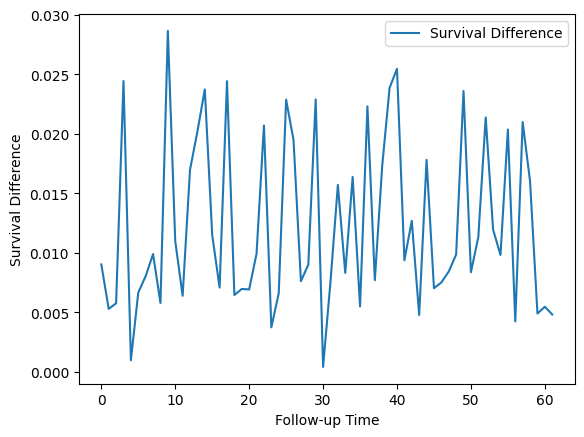

In [15]:
# Plot survival difference
import matplotlib.pyplot as plt
plt.plot(range(len(preds)), preds, label='Survival Difference')
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.legend()
plt.show()